In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
pd.set_option('max_columns', 300)
pd.set_option('max_rows', 1000)

#elimino i warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
#plotly
import plotly.plotly as py #import plotly
import plotly.graph_objs as go #import graphs objects
from plotly import tools #used for sublopts

#offline mode
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode()

# Climate data

In [3]:
rainfall=pd.read_csv('data_in/precipitazioni_pisa.csv',header=16,sep=';')
rainfall.head(2)

gg/mm/aaaa Precipitazione [mm] Tipo Dato
0  01/01/2004                 0,0         V
1  02/01/2004                 9,4         V

In [4]:
rainfall['gg/mm/aaaa']=pd.to_datetime(rainfall['gg/mm/aaaa'], format='%d/%m/%Y', errors='ignore')

In [5]:
rainfall=rainfall.rename(columns={'gg/mm/aaaa':'Day'})
rainfall=rainfall[['Day','Precipitazione [mm]']]
rainfall.head(2)

Day Precipitazione [mm]
0 2004-01-01                 0,0
1 2004-01-02                 9,4

In [6]:
temperature=pd.read_csv('data_in/temperature.csv',header=16,sep=';')
temperature['gg/mm/aaaa']=pd.to_datetime(temperature['gg/mm/aaaa'], format='%d/%m/%Y', errors='ignore')
temperature=temperature.rename(columns={'gg/mm/aaaa':'Day'})
temperature.head(2)

Day   Max  Min
0 2001-01-01  10.0  0.5
1 2001-01-02  14.0  6.0

In [7]:
climate=pd.merge(rainfall,temperature,how='outer',on='Day').sort_values('Day').fillna(0)
climate.head()

Day Precipitazione [mm]   Max  Min
5162 2001-01-01                   0  10.0  0.5
5163 2001-01-02                   0  14.0  6.0
5164 2001-01-03                   0  16.0  8.0
5165 2001-01-04                   0  12.0  6.0
5166 2001-01-05                   0  12.0  3.5

In [8]:
climate_2015=climate[(climate['Day']>='2015-01-01') & (climate['Day']<'2016-01-01')].reset_index(drop=True)
climate_2015.head()

Day Precipitazione [mm]   Max  Min
0 2015-01-01                 0,0   9.7 -2.3
1 2015-01-02                 0,0  12.7 -0.3
2 2015-01-03                 0,0  10.3  4.5
3 2015-01-04                 0,0  15.8  6.6
4 2015-01-05                 0,0  14.2  2.9

In [9]:
climate_2015['Mean']=(climate_2015['Min']+climate_2015['Max'])/2

In [10]:
trace= go.Scatter(
    x=climate_2015['Day'],
    y=climate_2015['Precipitazione [mm]']

)

data=[trace]

fig=go.Figure(data=data)
iplot(fig)

In [11]:
trace_1= go.Scatter(
    x=climate_2015['Day'],
    y=climate_2015['Max'],
    name='Max',
    line=dict(
        color='red'
    )  
)

trace_2= go.Scatter(
    x=climate_2015['Day'],
    y=climate_2015['Min'],
    name='Min',
    line=dict(
        color='blue'
    )
)

trace_3= go.Scatter(
    x=climate_2015['Day'],
    y=climate_2015['Mean'],
    name='Mean',
    line=dict(
        color='gray'
    )
)

data=[trace_1,trace_2,trace_3]

fig=go.Figure(data=data)
iplot(fig)

In [12]:
climate_2015.to_csv('data_in/04_clima_2015.csv', sep=';',index=False)

# Holiday data

In [13]:
holiday=pd.read_csv('data_in/fcal_Pisa_2015.csv',sep=';')
holiday.head()

giorno day_of_week  week_of_year               name religious  type
0  01/01/2015          Gi             1          Capodanno         F     1
1  06/01/2015          Ma             2           Epifania         T     1
2  29/03/2015          Do            13           Le Palme         T     5
3  29/03/2015          Do            13  Inizio ora legale         F     5
4  05/04/2015          Do            14             Pasqua         T     1

In [14]:
holiday['giorno']=pd.to_datetime(holiday['giorno'], format='%d/%m/%Y')

remove type 5

In [15]:
holiday=holiday[holiday['type']!=5]
holiday

giorno day_of_week  week_of_year                          name  \
0  2015-01-01          Gi             1                     Capodanno   
1  2015-01-06          Ma             2                      Epifania   
4  2015-04-05          Do            14                        Pasqua   
5  2015-04-06          Lu            15  Lunedì di Pasqua - Pasquetta   
6  2015-04-25          Sa            17            Liberazione Italia   
7  2015-05-01          Ve            18              Festa del lavoro   
9  2015-05-24          Do            21                    Pentecoste   
10 2015-06-02          Ma            23        Festa della Repubblica   
11 2015-06-17          Me            25                   San Ranieri   
12 2015-08-15          Sa            33                    Ferragosto   
14 2015-11-01          Do            44                 Tutti i santi   
17 2015-12-08          Ma            50         Immacolata Concezione   
20 2015-12-25          Ve            52                        Natale   
21 2015-12-26          Sa            52                 Santo Stefano   

   religious  type  
0          F     1  
1          T     1  
4          T     1  
5          T     1  
6          F     1  
7          F     1  
9          T     4  
10         F     1  
11         T     4  
12         T     1  
14         T     1  
17         T     1  
20         T     1  
21         T     1

In [16]:
holiday=holiday[~holiday['name'].isin(['Pentecoste'])] #tilde character in ascii is ALT+126 and means NOT... isin()
holiday=holiday[['giorno','name','religious']]

In [17]:
holiday=holiday.rename(columns={'giorno':'Day','name':'holiday'})

In [18]:
holiday.to_csv('data_in/04_holiday.csv',sep=';',index=False)

# Geographic data

Ho usato openstreetmap per recuperare la posizione delle stazioni.

In particolare attraverso https://overpass-turbo.eu/ ho eseguito la seguente query:

<code>
[out:json][timeout:25][diff:"2000-01-01T00:00:00Z","2015-12-31T23:59:00Z"];
// gather results
(
  // query part for: “amenity=bicycle_rental”
  node["amenity"="bicycle_rental"]({{bbox}});
  way["amenity"="bicycle_rental"]({{bbox}});
  relation["amenity"="bicycle_rental"]({{bbox}});
);
// print results
out body;
>;
out skel qt;
</code>

In [19]:
from IPython.display import Image

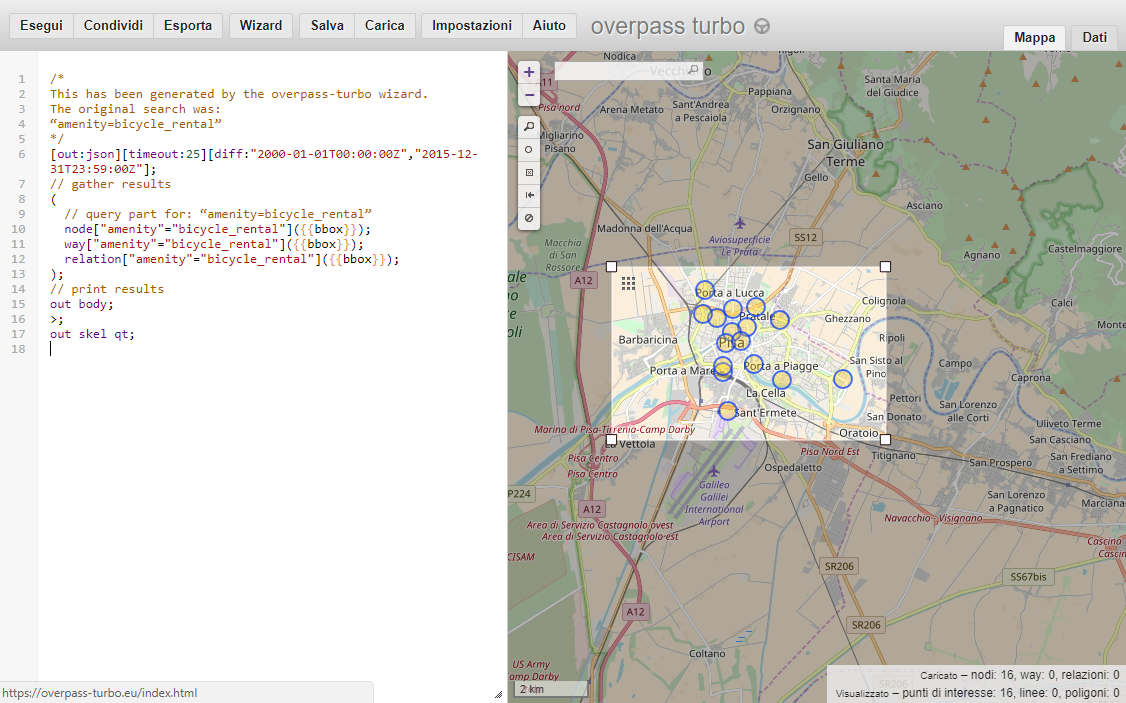

In [20]:
Image("data_in/overpass_turbo.PNG")

In [21]:
pd.read_json('data_in/bycicle_rental.geojson').head(2)

copyright  \
0  The data included in this document is from www...   
1  The data included in this document is from www...   

                                            features     generator  \
0  {'type': 'Feature', 'properties': {'@id': 'nod...  overpass-ide   
1  {'type': 'Feature', 'properties': {'@id': 'nod...  overpass-ide   

            timestamp               type  
0 2018-04-11 16:36:02  FeatureCollection  
1 2018-04-11 16:36:02  FeatureCollection

In [22]:
#import geopandas library to read geojson properly. In a conda console, with env activated: conda install geopandas

In [23]:
import geopandas as gpd

In [24]:
stazioni=gpd.read_file('data_in/bycicle_rental.geojson')

In [25]:
stazioni

id              @id         amenity   ref  network capacity  \
0   node/2260337097  node/2260337097  bicycle_rental  None     None     None   
1   node/2304886836  node/2304886836  bicycle_rental     2  CicloPi       28   
2   node/2343641547  node/2343641547  bicycle_rental    13  CicloPi       16   
3   node/2349733252  node/2349733252  bicycle_rental    14  CicloPi       24   
4   node/2349736452  node/2349736452  bicycle_rental     1  CicloPi       10   
5   node/2349963735  node/2349963735  bicycle_rental     8  CicloPi       30   
6   node/2350014465  node/2350014465  bicycle_rental     9  CicloPi       30   
7   node/2350017080  node/2350017080  bicycle_rental    10  CicloPi       30   
8   node/2350017749  node/2350017749  bicycle_rental     6  CicloPi       14   
9   node/2350019588  node/2350019588  bicycle_rental     5  CicloPi        9   
10  node/2350020344  node/2350020344  bicycle_rental     7  CicloPi       22   
11  node/2350021660  node/2350021660  bicycle_rental     3  CicloPi       16   
12  node/2350022607  node/2350022607  bicycle_rental    12  CicloPi       12   
13  node/2350022897  node/2350022897  bicycle_rental    11  CicloPi       14   
14  node/2923165076  node/2923165076  bicycle_rental    14  CicloPi       10   
15  node/3394054560  node/3394054560  bicycle_rental     4  CicloPi       12   

                  name                       geometry  
0                 None  POINT (10.3968511 43.7219688)  
1        Stazione F.S.  POINT (10.3989605 43.7084709)  
2    Vittorio Emanuele  POINT (10.3987825 43.7101854)  
3        Palacongressi  POINT (10.4097121 43.7106075)  
4            Aeroporto  POINT (10.4005415 43.6989552)  
5        Pietrasantina  POINT (10.3928733 43.7290165)  
6            Paparelli   POINT (10.410243 43.7246423)  
7              Pratale  POINT (10.4184265 43.7215365)  
8        Polo Marzotto  POINT (10.4071847 43.7198029)  
9        Borgo Stretto  POINT (10.4021322 43.7184126)  
10               Duomo  POINT (10.3919852 43.7228627)  
11  Comune Palazzo Blu  POINT (10.3998955 43.7157647)  
12      Sms Biblioteca  POINT (10.4191334 43.7065577)  
13  Ospedale Cisanello  POINT (10.4401533 43.7067956)  
14       Porta a Lucca  POINT (10.4022602 43.7242476)  
15    Teatro Tribunale  POINT (10.4051037 43.7163803)

In [29]:
stazioni=stazioni.iloc[1:,5:]

In [35]:
stazioni['lon']=stazioni.geometry.x
stazioni['lat']=stazioni.geometry.y
stazioni.head()

capacity               name                       geometry        lon  \
1       28      Stazione F.S.  POINT (10.3989605 43.7084709)  10.398960   
2       16  Vittorio Emanuele  POINT (10.3987825 43.7101854)  10.398782   
3       24      Palacongressi  POINT (10.4097121 43.7106075)  10.409712   
4       10          Aeroporto  POINT (10.4005415 43.6989552)  10.400541   
5       30      Pietrasantina  POINT (10.3928733 43.7290165)  10.392873   

         lat  
1  43.708471  
2  43.710185  
3  43.710608  
4  43.698955  
5  43.729017

In [38]:
stazioni.to_file('data_in/05_stazioni.geojson', driver="GeoJSON")